# 🚀 Unique identifier Embeddings in Neural Networks: Deep Dive, Pitfalls, and Rescue

### A practical and theoretical deep dive on why using raw identifiers like `customerId` as a feature leads to overfitting — and how to fix it!


## 1. Introduction

In recommendation systems and personalization models, **customerId** often seems like a natural input feature.

But **should you use it directly** in a neural network model?

The short answer: **It depends**.  
Using customer IDs without care can lead to **overfitting**, **poor generalization**, and a **fragile model**. In this notebook, we'll explore why and walk through a full **PyTorch mini-project** demonstrating the pitfalls — plus how we can "rescue" a model using **dropout** and **L2 regularization**.


Before diving deep into code, some background:

Neural networks are fundamentally high variance models as they have many parameters (i.e., complex model). Unless we have enough data (in our case, per customerId), instead of learning general patterns, it could end up memorizing training data and have poor performance on unseen data.

And iff the model should generalize across users, it is generally not recommended to use customerId as a feature. 


**Are we using customerId as raw feature ?**

* If you just dump the customerId (like an integer or string) directly into a model, it usually doesn’t help. Neural networks can't infer any meaning from a random ID — it's just a unique key.
* Worse, if you treat it as a number, the model might assume an ordering that doesn’t exist (customerId 1003 is "more" than 1002? No...).

  This is like feeding the model random noise: it can overfit but not generalize.

**Are we using customerId as categorical embedding ?**
* You can embed customerId the same way we embed words in NLP.
* In this case, customerId becomes a lookup table where each customer gets a learned vector.
* This is common in recommendation systems, personalization models, user-specific predictions, etc.

  Here, customerId → embedding layer → dense vector → fed into rest of the network.


In general we should look into alternatives where we focus on behavioral features not customerId. For example in product sales domain:
* Lifetime value
* churn probablity
* number of purchases
* demographic info
* Aggregate product embeddings (for example mean of item embeddings they interacted with)
* and so on...

Also, do not rely on customerId embeddings if you do *not* have a clold start strategy -- strategies like using location/demographic features/initial few interactions.


**Summary**: If you have millions of customers but small data per customer, using customerId as an embedding can overfit hard — network just memorizes behaviors. Regularization techniques like dropout, weight decay, or embedding pruning become important in this case.

**The plan for this notebook**

We test above on an example using synthetic data to demonstrate that naively using customerId leads to overfitting and poor generalization.

* We generate fake customers and products.
* We simulate interactions with simple rules.

We train three models:
* Model A: Uses raw customerId embedding.
* Model B: Uses behavior-based features only (no customerId).
* Model C: Rescue model with L2 regularization + dropout

We'll compare how they perform on unseen test data.

## 2. Simulated dataset

In [16]:

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [17]:
np.random.seed(42)

num_customers = 1000
num_products = 100
interactions_per_customer = 5

customer_ids = np.arange(num_customers)
product_ids = np.arange(num_products)

# Simulate true preference score per product
true_product_scores = np.random.rand(num_products)

data = []

for customer_id in customer_ids:
    preferred = np.random.choice(product_ids, 3, replace=False)
    for _ in range(interactions_per_customer):
        product_id = np.random.choice(product_ids)
        liked = int(product_id in preferred)
        # Fake feature: number of prior interactions with products (simulated)
        behavior_score = np.random.rand() * (liked + 0.1)
        data.append([customer_id, product_id, behavior_score, liked])

df = pd.DataFrame(data, columns=["customerId", "productId", "behaviorFeature", "label"])

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)


## 3. Dataset Class

In [18]:

class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, df, use_customer_id=True):
        self.customer_ids = torch.tensor(df["customerId"].values, dtype=torch.long)
        self.product_ids = torch.tensor(df["productId"].values, dtype=torch.long)
        self.behavior = torch.tensor(df["behaviorFeature"].values, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(df["label"].values, dtype=torch.float32).unsqueeze(1)
        self.use_customer_id = use_customer_id

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if self.use_customer_id:
            return self.customer_ids[idx], self.product_ids[idx], self.behavior[idx], self.labels[idx]
        else:
            return self.product_ids[idx], self.behavior[idx], self.labels[idx]


## 4. Model Definitions

In [19]:

# Model A: With CustomerId
class WithCustomerId(nn.Module):
    def __init__(self, num_customers, num_products):
        super().__init__()
        self.customer_embed = nn.Embedding(num_customers, 8)
        self.product_embed = nn.Embedding(num_products, 8)
        self.fc = nn.Sequential(
            nn.Linear(8 + 8 + 1, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, customer_id, product_id, behavior_feat):
        ce = self.customer_embed(customer_id)
        pe = self.product_embed(product_id)
        x = torch.cat([ce, pe, behavior_feat], dim=1)
        return self.fc(x)

# Model B: Without CustomerId
class WithoutCustomerId(nn.Module):
    def __init__(self, num_products):
        super().__init__()
        self.product_embed = nn.Embedding(num_products, 8)
        self.fc = nn.Sequential(
            nn.Linear(8 + 1, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, product_id, behavior_feat):
        pe = self.product_embed(product_id)
        x = torch.cat([pe, behavior_feat], dim=1)
        return self.fc(x)

# Rescue Model C: With Dropout + L2 Regularization
class WithCustomerIdDropout(nn.Module):
    def __init__(self, num_customers, num_products):
        super().__init__()
        self.customer_embed = nn.Embedding(num_customers, 8)
        self.product_embed = nn.Embedding(num_products, 8)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Sequential(
            nn.Linear(8 + 8 + 1, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, customer_id, product_id, behavior_feat):
        ce = self.customer_embed(customer_id)
        pe = self.product_embed(product_id)
        x = torch.cat([ce, pe, behavior_feat], dim=1)
        x = self.dropout(x)
        return self.fc(x)


## 5. Training and Evaluation Functions

In [20]:

def train_epoch(model, dataloader, optimizer, criterion, use_customer_id):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        if use_customer_id:
            customer_id, product_id, behavior, label = batch
            pred = model(customer_id, product_id, behavior)
        else:
            product_id, behavior, label = batch
            pred = model(product_id, behavior)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * label.size(0)
    return total_loss / len(dataloader.dataset)

def evaluate_model(model, dataloader, use_customer_id):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            if use_customer_id:
                customer_id, product_id, behavior, label = batch
                pred = model(customer_id, product_id, behavior)
            else:
                product_id, behavior, label = batch
                pred = model(product_id, behavior)
            preds.extend(pred.squeeze().tolist())
            labels.extend(label.squeeze().tolist())
    return roc_auc_score(labels, preds)


## 6. Train Models and Visualize Results

Epoch 1: Loss A=0.2254, AUC A=0.6845 | Loss B=0.2814, AUC B=0.4996
Epoch 2: Loss A=0.1136, AUC A=0.8142 | Loss B=0.1274, AUC B=0.7050
Epoch 3: Loss A=0.0914, AUC A=0.8426 | Loss B=0.1089, AUC B=0.8025
Epoch 4: Loss A=0.0739, AUC A=0.8563 | Loss B=0.0936, AUC B=0.8365
Epoch 5: Loss A=0.0599, AUC A=0.8690 | Loss B=0.0787, AUC B=0.8663
Epoch 6: Loss A=0.0489, AUC A=0.8485 | Loss B=0.0582, AUC B=0.8941
Epoch 7: Loss A=0.0390, AUC A=0.8565 | Loss B=0.0425, AUC B=0.9021
Epoch 8: Loss A=0.0319, AUC A=0.8449 | Loss B=0.0362, AUC B=0.9118
Epoch 9: Loss A=0.0259, AUC A=0.8315 | Loss B=0.0311, AUC B=0.9190
Epoch 10: Loss A=0.0220, AUC A=0.8372 | Loss B=0.0286, AUC B=0.9168
Epoch 11: Loss A=0.0184, AUC A=0.8354 | Loss B=0.0264, AUC B=0.9093
Epoch 12: Loss A=0.0158, AUC A=0.8367 | Loss B=0.0242, AUC B=0.9220
Epoch 13: Loss A=0.0136, AUC A=0.8357 | Loss B=0.0226, AUC B=0.9242
Epoch 14: Loss A=0.0118, AUC A=0.8343 | Loss B=0.0219, AUC B=0.9178
Epoch 15: Loss A=0.0106, AUC A=0.8339 | Loss B=0.0215, AU

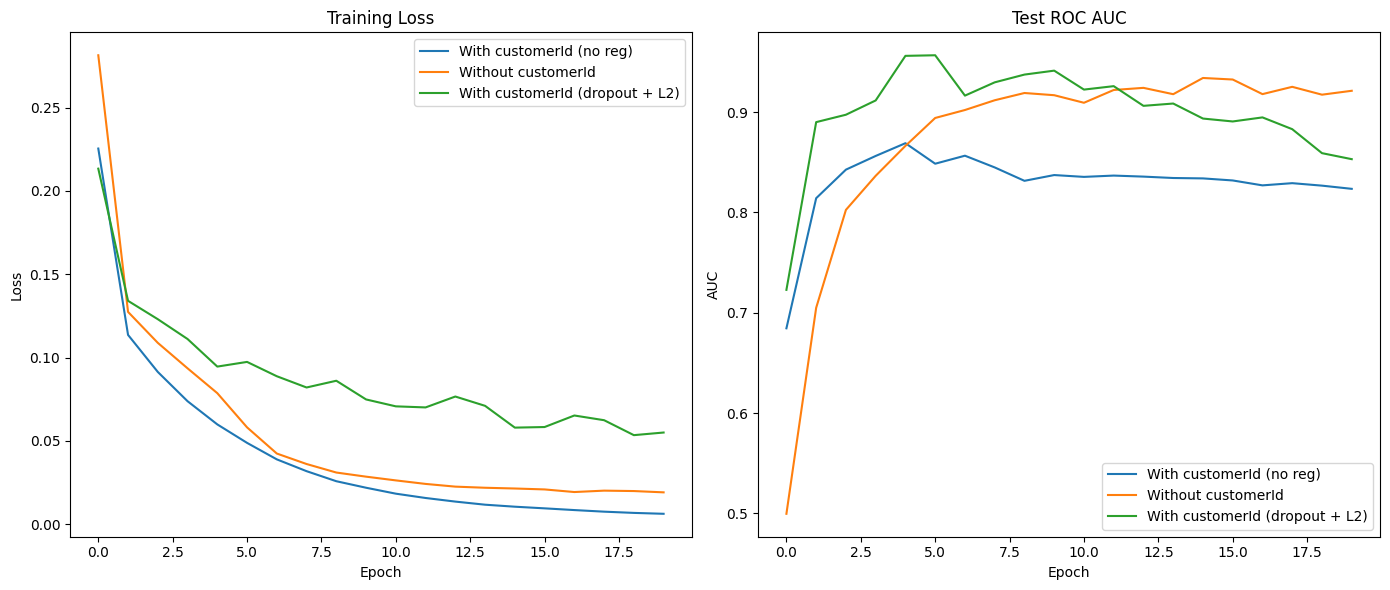

In [21]:

# Prepare datasets and loaders
train_set_a = SimpleDataset(train_df, use_customer_id=True)
test_set_a = SimpleDataset(test_df, use_customer_id=True)
train_set_b = SimpleDataset(train_df, use_customer_id=False)
test_set_b = SimpleDataset(test_df, use_customer_id=False)

train_loader_a = torch.utils.data.DataLoader(train_set_a, batch_size=64, shuffle=True)
test_loader_a = torch.utils.data.DataLoader(test_set_a, batch_size=64)
train_loader_b = torch.utils.data.DataLoader(train_set_b, batch_size=64, shuffle=True)
test_loader_b = torch.utils.data.DataLoader(test_set_b, batch_size=64)

# Initialize models
model_a = WithCustomerId(num_customers=1000, num_products=100)
optimizer_a = optim.Adam(model_a.parameters(), lr=0.01)

model_b = WithoutCustomerId(num_products=100)
optimizer_b = optim.Adam(model_b.parameters(), lr=0.01)

model_c = WithCustomerIdDropout(num_customers=1000, num_products=100)
optimizer_c = optim.Adam(model_c.parameters(), lr=0.01, weight_decay=1e-4)  # L2 regularization

criterion = nn.BCELoss()

losses_a, aucs_a = [], []
losses_b, aucs_b = [], []
losses_c, aucs_c = [], []

for epoch in range(20):
    loss_a = train_epoch(model_a, train_loader_a, optimizer_a, criterion, use_customer_id=True)
    loss_b = train_epoch(model_b, train_loader_b, optimizer_b, criterion, use_customer_id=False)
    loss_c = train_epoch(model_c, train_loader_a, optimizer_c, criterion, use_customer_id=True)

    auc_a = evaluate_model(model_a, test_loader_a, use_customer_id=True)
    auc_b = evaluate_model(model_b, test_loader_b, use_customer_id=False)
    auc_c = evaluate_model(model_c, test_loader_a, use_customer_id=True)

    losses_a.append(loss_a)
    losses_b.append(loss_b)
    losses_c.append(loss_c)
    aucs_a.append(auc_a)
    aucs_b.append(auc_b)
    aucs_c.append(auc_c)

    print(f"Epoch {epoch+1}: Loss A={loss_a:.4f}, AUC A={auc_a:.4f} | Loss B={loss_b:.4f}, AUC B={auc_b:.4f}")


# Plot losses and AUCs
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(losses_a, label="With customerId (no reg)")
plt.plot(losses_b, label="Without customerId")
plt.plot(losses_c, label="With customerId (dropout + L2)")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(aucs_a, label="With customerId (no reg)")
plt.plot(aucs_b, label="Without customerId")
plt.plot(aucs_c, label="With customerId (dropout + L2)")
plt.title("Test ROC AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()


## 7. What the plot shows?


**Training loss**

* Model A (with customerId) may have slightly lower loss

**Test ROC AUC**
* Model with customerId will struggle or even get worse after some epochs (overfitting)
* Model without customerId generalizes better

**Why**
* customerId-based model memorizes patterns tied to specific customers seen during training.
* When it sees new customers or new customer-product pairs at test time, it cannot generalize.


**Rescuing**

The goal is to see if we can "rescue" the model that uses customerId so it doesn’t overfit as badly with:
* Dropout (to prevent over-relying on customer embeddings) and
* L2 Regularization (also called weight decay)

As you can see in above plots, it is:

* Less overfitting
* Improved generalization (higher test AUC compared to plain customerId model)
* Still might not beat the behavior-only model if the customer data is too sparse.



## 8. Why Does Using CustomerId Cause Overfitting?


**Bias-Variance Perspective**

Including unique identifiers like CustomerId in a neural network leads to severe overfitting because it forces the model to memorize noise rather than learn generalizable patterns. This manifests as:

* Low Bias, High Variance:
  * The model achieves near-perfect training accuracy (low bias) by treating each CustomerId as a separate, memorizable pattern (e.g., via embeddings).
  * However, its predictions become extremely sensitive to the training set (high variance). A small change in the training data (e.g., swapping one customer for another) drastically alters the model’s weights.
* Failure to Generalize:
  * At test time, new customers have unseen CustomerId values. Since the model learned no meaningful structure (only memorization), test error explodes.
  * This is a classic case of high model capacity (ability to fit arbitrary patterns) mismatched with low effective sample size (few/no repeated observations per ID).
* Bias-Variance Tradeoff Breakdown:
  * Ideal: A good model balances bias (underfitting) and variance (overfitting) by learning patterns that generalize.
  * With CustomerId: The model "cheats" by exploiting the uniqueness of IDs, achieving zero training error but failing on any out-of-sample data.
* When Would This Not Happen?
  * If each CustomerId had many repeated observations, the model could learn meaningful shared patterns (e.g., "customer X prefers category Y").
  * But with one/few samples per ID, the model treats each as an independent, memorizable exception.

A high-capacity neural network can fit anything, but needs more data to generalize.

Think of this way: The real-world (population) has an intrinsic amount of variance -- independent of any modeling choices. However, including customerId artificially inflates the apparant complexit of the problem the model needs to solve. Rather than learning patterns that generalize across customers, the model tries to memorize customer-centric quirks that do not transfer to new customers. And since (neural network) model is complex, it has the capacity to fit thes per-customer idiosyncracies. And this leads to high model variance. As mentioned above, if we sample a slightly different dataset (with different customers), the model's learned weights change drastically because it must memorize a different set of customer-specific patterns. This sensitivity to the training data means that predictions on unseen customers are unstable and error-prone. This high variance directs leads to poor generalization, as predicted by the bias-variance tradeoff.

It is important to note that the overfitting would be much less severage if we had a large number of examples per customer. With enough data per CustomerId, the model could learn a meaningful, robust representation of each customer rather than overfitting to random noise.


## 9. Key takeaways


* Never use customerId raw.
* Embedding + dropout + regularization can save you — but only partially.
* Behavior-based features are the most reliable foundation for cold-start and generalization.
* Good model design ≠ memorization; it's about pattern discovery.
